In [1]:
# pip install numpy
# pip install pandas
# pip install matplotlib
# pip install pandas-datareader
# pip install tensorflow
# pip install sklearn
# pip install scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

C:\Users\DELL\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [9]:
# from pandas_datareader import data as pdr
# import pandas_datareader
import yfinance as yf
# yf.pdr_override()

crypto_currency = 'BTC'
# against_currency = 'USD'

# start = dt.datetime(2016, 1, 1)
# end = dt.datetime.now()

# data = pdr.DataReader(f'{crypto_currency}-{against_currency}', start, end)  # i got error here # do not use 'yahoo' in this statement # now i dont know why this line is giving error as previously it was working fine
data = yf.download(tickers='BTC-USD', period='7y', interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-23,445.860992,450.282013,444.330994,450.282013,450.282013,50485400
2016-04-24,450.559998,460.145996,448.928009,458.554993,458.554993,68198400
2016-04-25,459.121002,466.619995,453.592010,461.425995,461.425995,87091800
2016-04-26,461.648010,467.964996,461.621002,466.088989,466.088989,78971904
2016-04-27,466.261993,467.079010,444.134003,444.687012,444.687012,93564896
...,...,...,...,...,...,...
2023-04-19,30394.187500,30411.054688,28669.898438,28822.679688,28822.679688,24571565421
2023-04-20,28823.683594,29076.400391,28037.257812,28245.988281,28245.988281,21340360360
2023-04-21,28249.230469,28349.968750,27177.365234,27276.910156,27276.910156,20759504330


# Prepare Data

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# Create Neural Network

In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))        # i got error here # do not use model.dense(units=1)
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
79/79 [==============================] - 11s 49ms/step - loss: 0.0092
Epoch 2/25
79/79 [==============================] - 4s 46ms/step - loss: 0.0035
Epoch 3/25
79/79 [==============================] - 3s 42ms/step - loss: 0.0026
Epoch 4/25
79/79 [==============================] - 4s 46ms/step - loss: 0.0024
Epoch 5/25
79/79 [==============================] - 4s 46ms/step - loss: 0.0020
Epoch 6/25
79/79 [==============================] - 4s 46ms/step - loss: 0.0021
Epoch 7/25
79/79 [==============================] - 3s 43ms/step - loss: 0.0020
Epoch 8/25
79/79 [==============================] - 3s 42ms/step - loss: 0.0021
Epoch 9/25
79/79 [==============================] - 3s 42ms/step - loss: 0.0017
Epoch 10/25
79/79 [==============================] - 3s 42ms/step - loss: 0.0017
Epoch 11/25
79/79 [==============================] - 3s 42ms/step - loss: 0.0015
Epoch 12/25
79/79 [==============================] - 3s 42ms/step - loss: 0.0021
Epoch 13/25
79/79 [=================

# Testing the Model

In [6]:
# test_start = dt.datetime(2020, 1, 1)
# test_end = dt.datetime(2023, 1, 1)

# test_data = pdr.DataReader(f'{crypto_currency}-{against_currency}', test_start, test_end)
test_data = yf.download(tickers='BTC-USD', period='3y', interval='1d')


actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)



[*********************100%***********************]  1 of 1 completed
35/35 [==============================] - 2s 15ms/step


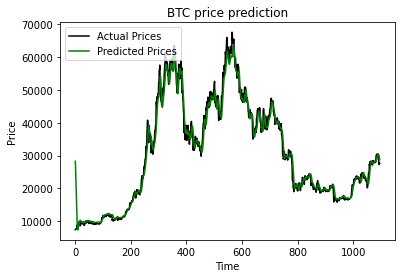

In [10]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Predict next day

In [11]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 1s/step
[[28270.16]]
